In [1]:
from os import listdir
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plot
from math import sqrt
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
def readDataset(name):
    file = open(name, "r")
    readInts = lambda: list(map(int, file.readline().strip().split(' ')))

    n, cnt = readInts()
    m = readInts()[0] # classes count

    features, classes = [], []
    for i in range(m):
        line = readInts()
        features.append(list(map(float, line[:n])))
        classes.append(line[n])
#     for j in range(n):
#         s = sqrt(sum([features[i][j] * features[i][j] for i in range(m)]))
#         for i in range(m):
#             features[i][j] /= s

    return np.array(features), np.array(classes)


def readDatasets(names):
    return [readDataset(name) for name in names]

In [3]:
testDatasets = readDatasets(['DT_txt/{:02d}_test.txt'.format(i) for i in range(1, 22)])
trainDatasets = readDatasets(['DT_txt/{:02d}_train.txt'.format(i) for i in range(1, 22)])

In [55]:
class Node:

    def __init__(self, result = None, index = None, threshold = None):
        self.left = None
        self.right = None
        self.result = result
        self.index = index
        self.threshold = threshold

    def classify(self, features):
        if self.result != None:
            return self.result
        if features[self.index] < self.threshold:
            return self.left.classify(features)
        else:
            return self.right.classify(features)
    
    def write(self, v = 1, prnt=True):
        if self.result != None:
            if prnt:
                print('C {0}'.format(self.result))
            return v
        else:
            l = v + 1
            mxl = self.left.write(l, False)
            r = mxl + 1
            if prnt:
                print('Q {0} {1} {2} {3}'.format(self.index + 1, self.threshold, l, r))
            self.left.write(l, prnt)
            mxr = self.right.write(r, prnt)
            return mxr

In [56]:
def giniGain(frequences):
    s = np.sum(frequences)
    P = frequences * frequences / (s ** 2)
    return 1.0 - np.sum(P)

In [57]:
def informativeness(frequences, frequences1, frequences2):
    sz1 = sum(frequences1)
    sz2 = sum(frequences2)
    sz = sz1 + sz2
    return giniGain(frequences) - giniGain(frequences1) * sz1/sz - giniGain(frequences2) * sz2/sz

In [58]:
def newPredicate(features, i, threshold):
    return features[:, i] < threshold

In [66]:
def split(features, classes):
    n = len(features[0])
    m = len(features)
    bestInf = -1e5
    bestIndex = 0
    bestTreshold = 0
    bestTresholdIndex = 0
    
    for j in range(n):
#         tmp = [(features[i], classes[i]) for i in range(len(features))]
#         tmp.sort(key=lambda f: f[0][j])
#         features = np.array([t[0] for t in tmp])
#         classes = np.array([t[1] for t in tmp])
#         features.sort(key=lambda f: f[j])
        for i in range(m - 1):
            treshold = features[i][j] + 0.01
            predicate = newPredicate(features, j, treshold)

            classes1, classes2 = classes[predicate], classes[~predicate]
            
#             classes1, classes2 = [], []
#             for k in range(m):
#                 if features[k][j] < treshold:
#                     classes1.append(classes[k])
#                 else:
#                     classes2.append(classes[k])
            inf = informativeness(np.bincount(classes), np.bincount(classes1), np.bincount(classes2))
            
#             print()
#             print('classes : {0}, classes1 : {1}, classes2 : {2}'.format(classes, classes1, classes2))
#             print('len(features) : {0}, index : {1}, treshold : {2}, inf: {3}'.format(len(features), j, treshold, inf))
            
            if inf > bestInf:
                bestInf, bestIndex, bestTreshold, bestTresholdIndex = inf, j, treshold, i
    
#     print('len(features) : {0}, bestIndex : {1}, bestTreshold : {2}, bestInf: {3}'.format(len(features), bestIndex, bestTreshold, bestInf))
    
    return bestIndex, bestTreshold

In [60]:
def buildTree(features, classes, maxLength, chooseFeatures = id):
    
    if len(features) == 0:
        print('EMPTY!!!')
        return Node(result=0)
    
    classFrequencies = np.bincount(classes)
    if maxLength == 0:
        maxClass = np.argmax(classFrequencies)
        return Node(result=maxClass)

    existingClasses = np.nonzero(classFrequencies)[0]
    if len(existingClasses) == 1:
        return Node(result=existingClasses[0])

    subFeatures = chooseFeatures(features)
    index, threshold = split(features, classes)

    predicate = newPredicate(features, index, threshold)
    features1, features2 = features[predicate], features[~predicate]
    classes1, classes2 = classes[predicate], classes[~predicate]
#     features1, features2 = [], []
#     classes1, classes2 = [], []
#     for i in range(len(features)):
#         if features[i][index] < threshold:
#             features1.append(features[i])
#             classes1.append(classes[i])
#         else:
#             features2.append(features[i])
#             classes2.append(classes[i])
    cur = Node(index=index, threshold=threshold)

    cur.left = buildTree(features1, classes1, maxLength - 1, chooseFeatures)
    cur.right = buildTree(features2, classes2, maxLength - 1, chooseFeatures)
    
    return cur

In [61]:
def quality(train, test, length):
    features, classes = train
    tree = buildTree(features, classes, length)
    
    classesOld = classes

    features, classes = test
    predicted = [tree.classify(f) for f in features]
    
    diff = sum(predicted[i] != classes[i] for i in range(len(classes)))
#     print('n={0}, diff={1}, unique(predicted)={2}, unique(classesOld)={3}, unique(classes)={4}'.format(len(classes), diff, np.unique(predicted), np.unique(classesOld), np.unique(classes)))
    
    return 1.0 - diff / len(classes)#accuracy_score(predicted, classes.tolist())

In [62]:
trainCF = readDataset('DT_txt/00.txt')
features, classes = trainCF
length = 2

tree = buildTree(features, classes, length)

tree.write()

Q 1 2.5 2 5
Q 2 2.5 3 4
C 1
C 4
Q 2 2.5 6 7
C 2
C 3


7

i=0, length=1, quality=0.6381392958108456
i=0, length=2, quality=0.864816242611154
i=0, length=3, quality=0.9994859933179131
i=0, length=4, quality=0.9982009766126959
i=0, length=5, quality=0.9964019532253919
i=0, length=6, quality=0.9938319198149576
i=0, length=7, quality=0.992289899768697
i=0, length=8, quality=0.9892058596761758
i=0, length=9, quality=0.9840657928553072
i=0, length=10, quality=0.9804677460806991


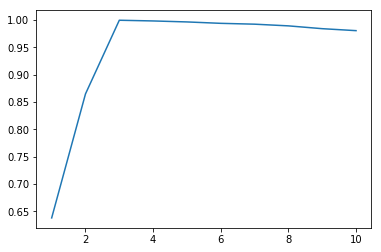

i = 0, best length: 3
i=1, length=1, quality=0.22697201017811708
i=1, length=2, quality=0.3595419847328244
i=1, length=3, quality=0.44122137404580153
i=1, length=4, quality=0.501526717557252
i=1, length=5, quality=0.5351145038167939
i=1, length=6, quality=0.5819338422391858
i=1, length=7, quality=0.6111959287531807
i=1, length=8, quality=0.6223918575063614
i=1, length=9, quality=0.6346055979643765
i=1, length=10, quality=0.6292620865139948


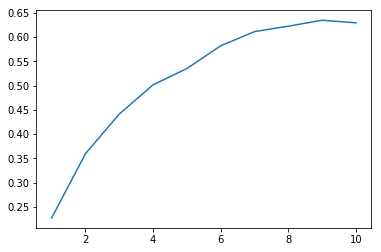

i = 1, best length: 9
i=2, length=1, quality=0.9995178399228544
i=2, length=2, quality=0.9985535197685632
i=2, length=3, quality=0.993731918997107
i=2, length=4, quality=0.9889103182256509
i=2, length=5, quality=0.9874638379942141
i=2, length=6, quality=0.9869816779170685
i=2, length=7, quality=0.9860173577627772
i=2, length=8, quality=0.9850530376084861
i=2, length=9, quality=0.982642237222758
i=2, length=10, quality=0.982642237222758


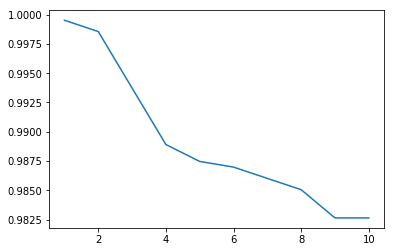

i = 2, best length: 1
i=3, length=1, quality=0.7060869565217391
i=3, length=2, quality=0.8493913043478261
i=3, length=3, quality=0.8779130434782608
i=3, length=4, quality=0.9624347826086956
i=3, length=5, quality=0.9881739130434782
i=3, length=6, quality=0.9801739130434782
i=3, length=7, quality=0.9780869565217392
i=3, length=8, quality=0.9746086956521739
i=3, length=9, quality=0.9725217391304348
i=3, length=10, quality=0.9690434782608696


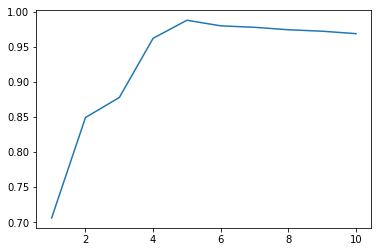

i = 3, best length: 5
i=4, length=1, quality=0.9978354978354979
i=4, length=2, quality=0.9978354978354979
i=4, length=3, quality=0.9978354978354979
i=4, length=4, quality=0.9956709956709957
i=4, length=5, quality=0.9956709956709957
i=4, length=6, quality=0.9891774891774892
i=4, length=7, quality=0.987012987012987
i=4, length=8, quality=0.9826839826839827
i=4, length=9, quality=0.9783549783549783
i=4, length=10, quality=0.9718614718614719


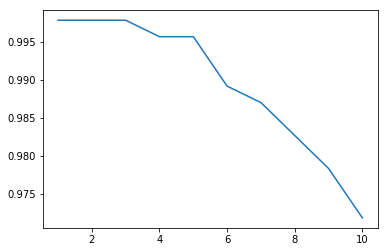

i = 4, best length: 1
i=5, length=1, quality=0.7935982339955849
i=5, length=2, quality=0.9613686534216336
i=5, length=3, quality=0.9928256070640177
i=5, length=4, quality=0.9911699779249448
i=5, length=5, quality=0.9862030905077263
i=5, length=6, quality=0.9856512141280354
i=5, length=7, quality=0.9817880794701986
i=5, length=8, quality=0.9762693156732892
i=5, length=9, quality=0.9729580573951435
i=5, length=10, quality=0.9718543046357616


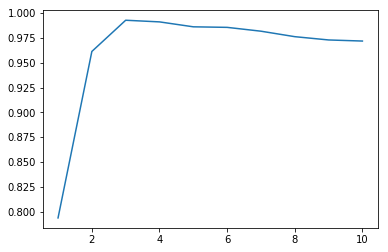

i = 5, best length: 3
i=6, length=1, quality=0.6213953488372093
i=6, length=2, quality=0.8488372093023255
i=6, length=3, quality=0.9920930232558139
i=6, length=4, quality=0.9855813953488373
i=6, length=5, quality=0.9776744186046512
i=6, length=6, quality=0.9725581395348837
i=6, length=7, quality=0.9702325581395349
i=6, length=8, quality=0.9665116279069768
i=6, length=9, quality=0.9655813953488372
i=6, length=10, quality=0.9618604651162791


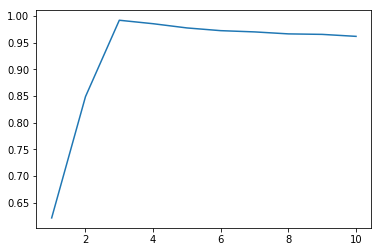

i = 6, best length: 3
i=7, length=1, quality=0.9708939708939709
i=7, length=2, quality=1.0
i=7, length=3, quality=1.0
i=7, length=4, quality=1.0
i=7, length=5, quality=1.0
i=7, length=6, quality=1.0
i=7, length=7, quality=0.9896049896049897
i=7, length=8, quality=0.9896049896049897
i=7, length=9, quality=0.9896049896049897
i=7, length=10, quality=0.9875259875259875


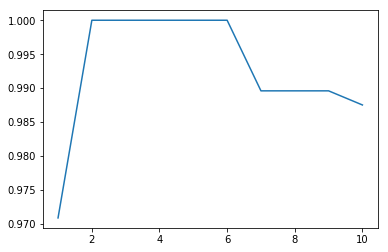

i = 7, best length: 2
i=8, length=1, quality=0.40784313725490196
i=8, length=2, quality=0.611764705882353
i=8, length=3, quality=0.7156862745098039
i=8, length=4, quality=0.803921568627451
i=8, length=5, quality=0.792156862745098
i=8, length=6, quality=0.7745098039215687
i=8, length=7, quality=0.7588235294117647
i=8, length=8, quality=0.7549019607843137
i=8, length=9, quality=0.7450980392156863
i=8, length=10, quality=0.7431372549019608


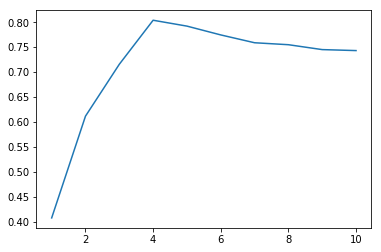

i = 8, best length: 4
i=9, length=1, quality=0.38953722334004026
i=9, length=2, quality=0.7311871227364185
i=9, length=3, quality=0.8647887323943662
i=9, length=4, quality=0.9915492957746479
i=9, length=5, quality=0.9855130784708249
i=9, length=6, quality=0.9835010060362173
i=9, length=7, quality=0.979476861167002
i=9, length=8, quality=0.9734406438631791
i=9, length=9, quality=0.96579476861167
i=9, length=10, quality=0.9561368209255533


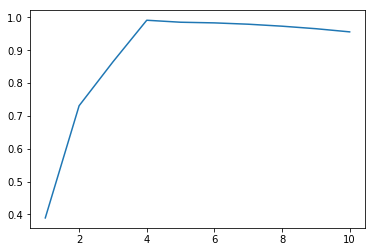

i = 9, best length: 4
i=10, length=1, quality=0.999195171026157
i=10, length=2, quality=0.9975855130784709
i=10, length=3, quality=0.9971830985915493
i=10, length=4, quality=0.9971830985915493
i=10, length=5, quality=0.9943661971830986
i=10, length=6, quality=0.9935613682092556
i=10, length=7, quality=0.9911468812877263
i=10, length=8, quality=0.986317907444668
i=10, length=9, quality=0.9839034205231388
i=10, length=10, quality=0.9830985915492958


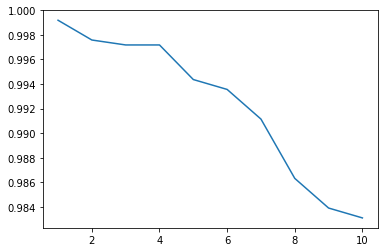

i = 10, best length: 1
i=11, length=1, quality=0.4451305079988773
i=11, length=2, quality=0.567218635980915
i=11, length=3, quality=0.6752736458040977
i=11, length=4, quality=0.7252315464496211
i=11, length=5, quality=0.788099915801291
i=11, length=6, quality=0.8504069604266068
i=11, length=7, quality=0.8664047151277013
i=11, length=8, quality=0.8678080269435868
i=11, length=9, quality=0.8678080269435868
i=11, length=10, quality=0.8602301431378052


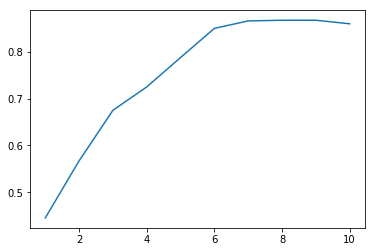

i = 11, best length: 8
i=12, length=1, quality=0.34678899082568804
i=12, length=2, quality=0.36880733944954125
i=12, length=3, quality=0.40458715596330275
i=12, length=4, quality=0.5064220183486239
i=12, length=5, quality=0.6027522935779817
i=12, length=6, quality=0.6045871559633027
i=12, length=7, quality=0.6256880733944954
i=12, length=8, quality=0.5880733944954128
i=12, length=9, quality=0.5871559633027523
i=12, length=10, quality=0.5807339449541284


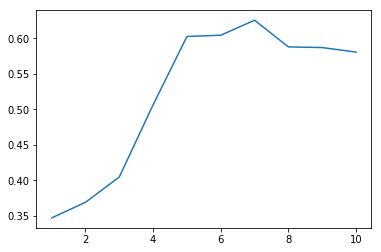

i = 12, best length: 7
i=13, length=1, quality=0.4677730605943651
i=13, length=2, quality=0.7116943265148592
i=13, length=3, quality=0.8317252026244693
i=13, length=4, quality=0.9127749903512158
i=13, length=5, quality=0.9540717869548437
i=13, length=6, quality=0.953299884214589


In [ ]:
bestLs = []
for i in range(21):
    train, test = trainDatasets[i], testDatasets[i]
    ls = []
    qs = []
    bestL = 1
    for length in range(1, 11):
        q = quality(train, test, length)
        ls.append(length)
        qs.append(q)
        if q > qs[bestL - 1]:
            bestL = length
        print('i={0}, length={1}, quality={2}'.format(i, length, q))
    bestLs.append(bestL)
    plt.plot(ls, qs)
    plt.show()
    print('i = {0}, best length: {1}'.format(i, bestL))

test = 1


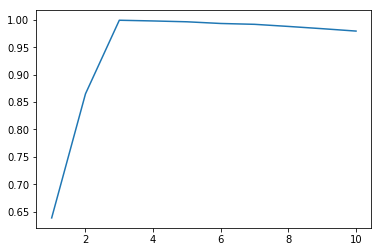

test = 2


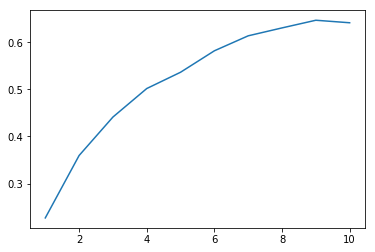

test = 3


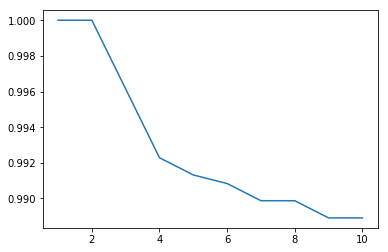

test = 4


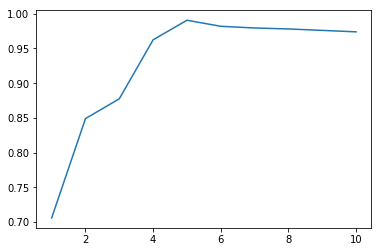

test = 5


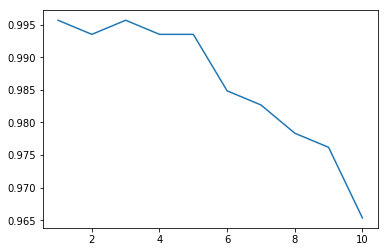

test = 6


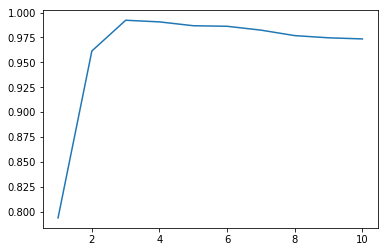

test = 7


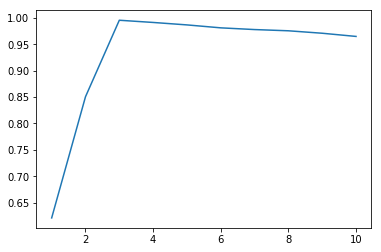

test = 8


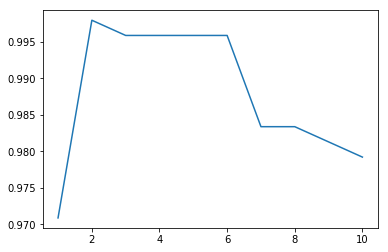

test = 9


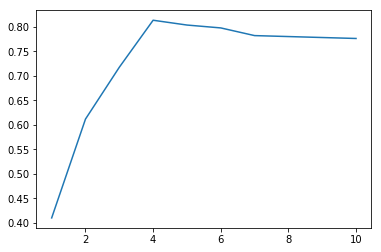

test = 10


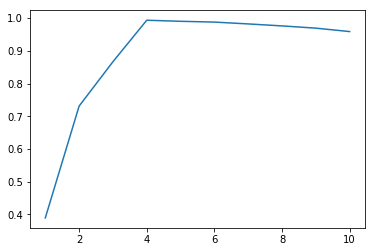

test = 11


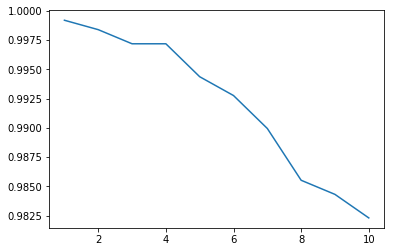

test = 12


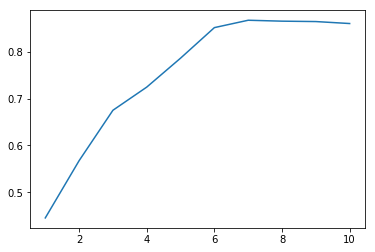

test = 13


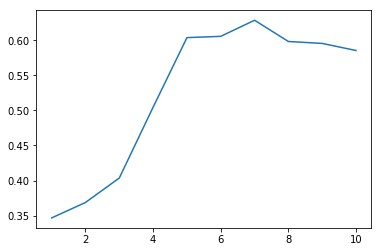

test = 14


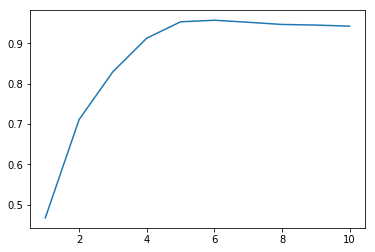

test = 15


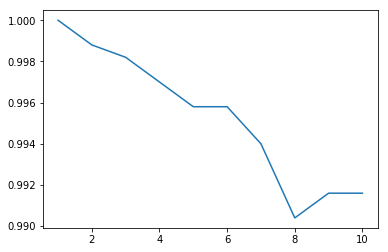

test = 16


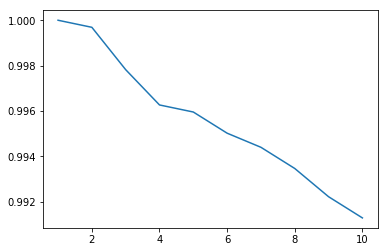

test = 17


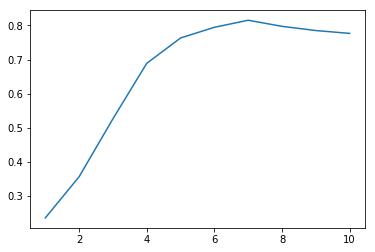

test = 18


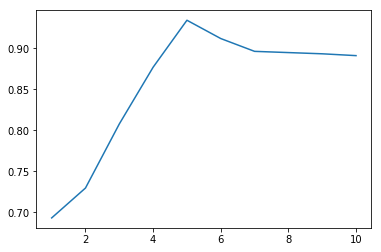

test = 19


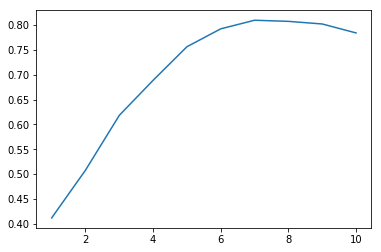

test = 20


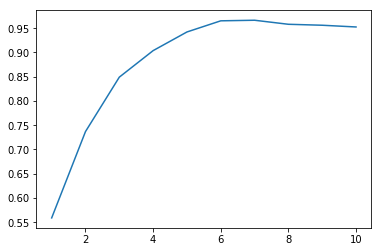

test = 21


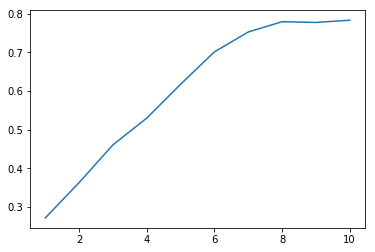

In [5]:
import matplotlib.pyplot as plt

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.638396, 0.865073, 0.999486, 0.998201, 0.996659, 0.993575, 0.992033, 0.988178, 0.984066, 0.979697, ]
print('test = {0}'.format(1))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.226972, 0.359542, 0.441221, 0.501781, 0.536387, 0.581934, 0.61374, 0.630534, 0.646819, 0.641476, ]
print('test = {0}'.format(2))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 1, 0.996143, 0.992285, 0.991321, 0.990839, 0.989875, 0.989875, 0.98891, 0.98891, ]
print('test = {0}'.format(3))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.706087, 0.849043, 0.877565, 0.962435, 0.990609, 0.981913, 0.979478, 0.978087, 0.976, 0.973913, ]
print('test = {0}'.format(4))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.995671, 0.993506, 0.995671, 0.993506, 0.993506, 0.984848, 0.982684, 0.978355, 0.97619, 0.965368, ]
print('test = {0}'.format(5))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.793598, 0.961369, 0.992274, 0.990618, 0.986755, 0.986203, 0.98234, 0.976821, 0.974614, 0.97351, ]
print('test = {0}'.format(6))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.62093, 0.850698, 0.995814, 0.991628, 0.986977, 0.981395, 0.97814, 0.975814, 0.971163, 0.965116, ]
print('test = {0}'.format(7))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.970894, 0.997921, 0.995842, 0.995842, 0.995842, 0.995842, 0.983368, 0.983368, 0.981289, 0.97921, ]
print('test = {0}'.format(8))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.409804, 0.611765, 0.717647, 0.813725, 0.803922, 0.798039, 0.782353, 0.780392, 0.778431, 0.776471, ]
print('test = {0}'.format(9))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.389537, 0.731187, 0.866801, 0.993561, 0.990342, 0.987928, 0.982294, 0.976258, 0.969416, 0.958954, ]
print('test = {0}'.format(10))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.999195, 0.99839, 0.997183, 0.997183, 0.994366, 0.992757, 0.98994, 0.985513, 0.984306, 0.982294, ]
print('test = {0}'.format(11))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.445411, 0.567499, 0.674993, 0.72439, 0.786135, 0.851249, 0.866966, 0.865001, 0.864159, 0.859949, ]
print('test = {0}'.format(12))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.346789, 0.368807, 0.40367, 0.504587, 0.60367, 0.605505, 0.62844, 0.598165, 0.595413, 0.585321, ]
print('test = {0}'.format(13))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.467387, 0.710922, 0.829409, 0.912389, 0.952914, 0.956773, 0.951756, 0.946353, 0.944809, 0.942107, ]
print('test = {0}'.format(14))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 0.998799, 0.998198, 0.996997, 0.995796, 0.995796, 0.993994, 0.99039, 0.991592, 0.991592, ]
print('test = {0}'.format(15))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 0.999688, 0.997819, 0.996262, 0.99595, 0.995016, 0.994393, 0.993458, 0.992212, 0.991277, ]
print('test = {0}'.format(16))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.236181, 0.356784, 0.526521, 0.689001, 0.763261, 0.794528, 0.815187, 0.79732, 0.785036, 0.776661, ]
print('test = {0}'.format(17))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.693224, 0.72971, 0.807893, 0.877141, 0.934475, 0.912137, 0.8965, 0.895011, 0.893522, 0.891288, ]
print('test = {0}'.format(18))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.411853, 0.507877, 0.618155, 0.688672, 0.756189, 0.792198, 0.809452, 0.807202, 0.80195, 0.783946, ]
print('test = {0}'.format(19))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.559033, 0.736926, 0.849049, 0.903724, 0.942155, 0.965135, 0.966323, 0.958003, 0.956022, 0.952456, ]
print('test = {0}'.format(20))
plt.plot(ls, qs)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.272036, 0.363348, 0.461002, 0.53012, 0.617628, 0.701332, 0.752695, 0.779328, 0.777425, 0.783133, ]
print('test = {0}'.format(21))
plt.plot(ls, qs)
plt.show()

test = 1


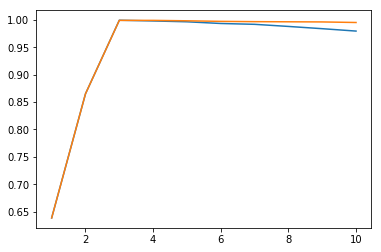

bestH =  3
test = 2


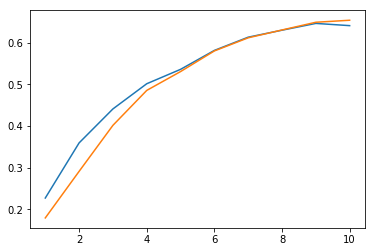

bestH =  9
test = 3


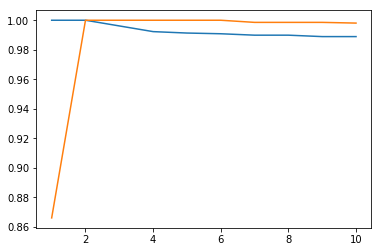

bestH =  1
test = 4


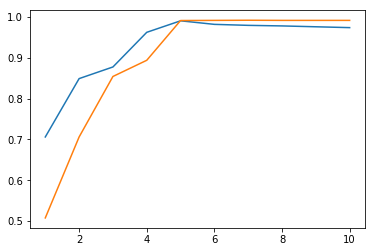

bestH =  5
test = 5


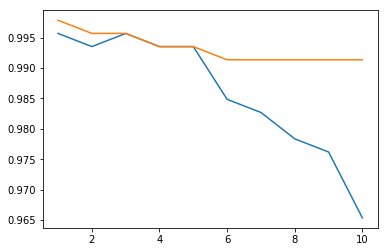

bestH =  1
test = 6


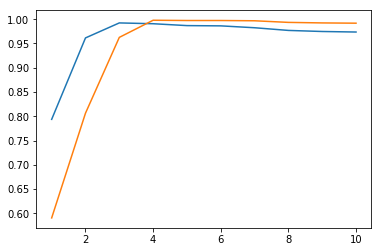

bestH =  3
test = 7


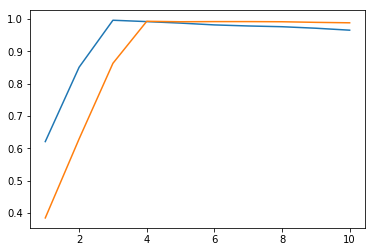

bestH =  3
test = 8


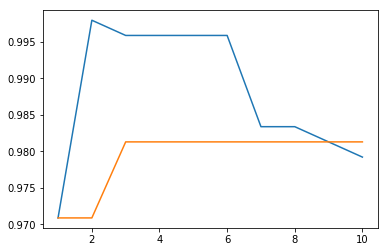

bestH =  2
test = 9


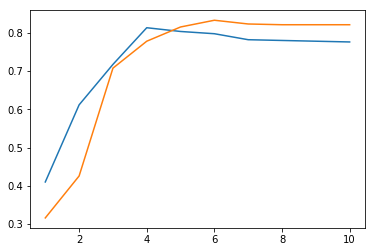

bestH =  4
test = 10


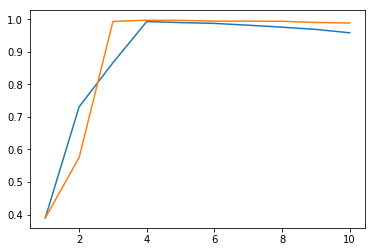

bestH =  4
test = 11


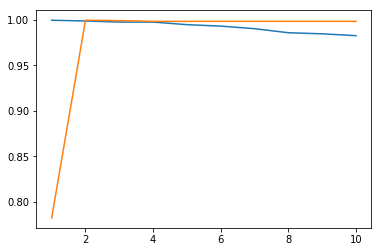

bestH =  1
test = 12


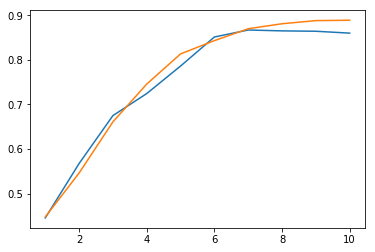

bestH =  7
test = 13


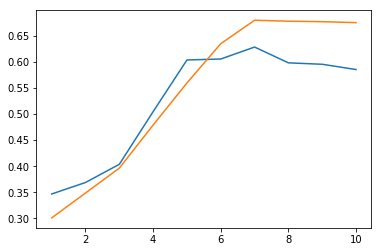

test = 14


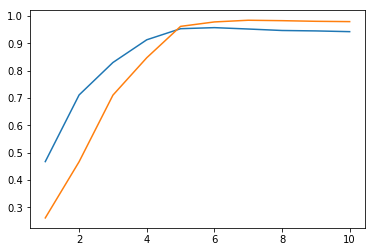

bestH =  6
test = 15


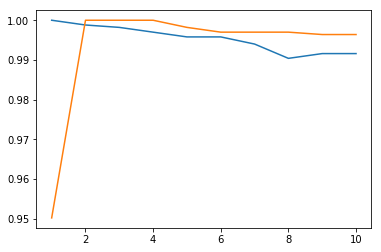

bestH =  1
test = 16


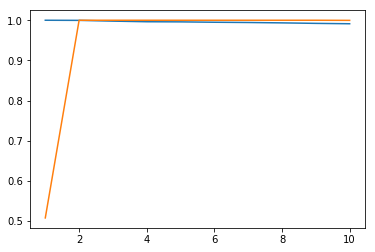

bestH =  1
test = 17


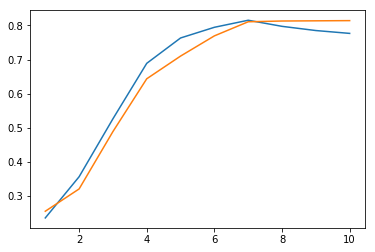

bestH =  7
test = 18


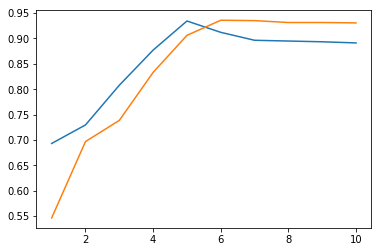

bestH =  5
test = 19


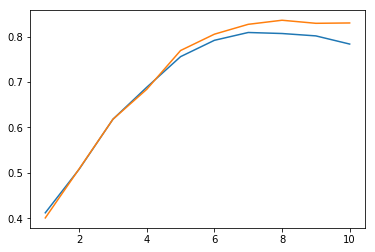

bestH =  7
test = 20


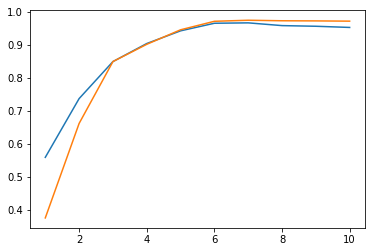

bestH =  7
test = 21


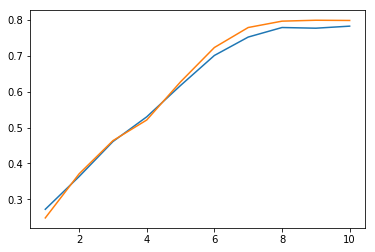

bestH =  10


In [9]:
import numpy as np
bestH = []

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.638396, 0.865073, 0.999486, 0.998201, 0.996659, 0.993575, 0.992033, 0.988178, 0.984066, 0.979697, ]
qsF = [0.638396, 0.865073, 0.999229, 0.999229, 0.998458, 0.99743, 0.996916, 0.996659, 0.996402, 0.995374, ]
print('test = {0}'.format(1))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.226972, 0.359542, 0.441221, 0.501781, 0.536387, 0.581934, 0.61374, 0.630534, 0.646819, 0.641476, ]
qsF = [0.179135, 0.291094, 0.401781, 0.485751, 0.531043, 0.580662, 0.612214, 0.631043, 0.649618, 0.654453, ]
print('test = {0}'.format(2))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 1, 0.996143, 0.992285, 0.991321, 0.990839, 0.989875, 0.989875, 0.98891, 0.98891, ]
qsF = [0.865959, 1, 1, 1, 1, 1, 0.998554, 0.998554, 0.998554, 0.998071, ]
print('test = {0}'.format(3))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.706087, 0.849043, 0.877565, 0.962435, 0.990609, 0.981913, 0.979478, 0.978087, 0.976, 0.973913, ]
qsF = [0.507826, 0.706087, 0.854261, 0.893913, 0.991304, 0.991652, 0.992, 0.991652, 0.991652, 0.991652, ]
print('test = {0}'.format(4))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.995671, 0.993506, 0.995671, 0.993506, 0.993506, 0.984848, 0.982684, 0.978355, 0.97619, 0.965368, ]
qsF = [0.997835, 0.995671, 0.995671, 0.993506, 0.993506, 0.991342, 0.991342, 0.991342, 0.991342, 0.991342, ]
print('test = {0}'.format(5))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.793598, 0.961369, 0.992274, 0.990618, 0.986755, 0.986203, 0.98234, 0.976821, 0.974614, 0.97351, ]
qsF = [0.590508, 0.806291, 0.962472, 0.997792, 0.997241, 0.997241, 0.996689, 0.993377, 0.992274, 0.991722, ]
print('test = {0}'.format(6))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.62093, 0.850698, 0.995814, 0.991628, 0.986977, 0.981395, 0.97814, 0.975814, 0.971163, 0.965116, ]
qsF = [0.385116, 0.629302, 0.862791, 0.992558, 0.991163, 0.991628, 0.991628, 0.991163, 0.989302, 0.987907, ]
print('test = {0}'.format(7))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.970894, 0.997921, 0.995842, 0.995842, 0.995842, 0.995842, 0.983368, 0.983368, 0.981289, 0.97921, ]
qsF = [0.970894, 0.970894, 0.981289, 0.981289, 0.981289, 0.981289, 0.981289, 0.981289, 0.981289, 0.981289, ]
print('test = {0}'.format(8))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.409804, 0.611765, 0.717647, 0.813725, 0.803922, 0.798039, 0.782353, 0.780392, 0.778431, 0.776471, ]
qsF = [0.315686, 0.42549, 0.707843, 0.778431, 0.815686, 0.833333, 0.823529, 0.821569, 0.821569, 0.821569, ]
print('test = {0}'.format(9))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.389537, 0.731187, 0.866801, 0.993561, 0.990342, 0.987928, 0.982294, 0.976258, 0.969416, 0.958954, ]
qsF = [0.389537, 0.57505, 0.993964, 0.997586, 0.997183, 0.994769, 0.994769, 0.994366, 0.990744, 0.989135, ]
print('test = {0}'.format(10))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.999195, 0.99839, 0.997183, 0.997183, 0.994366, 0.992757, 0.98994, 0.985513, 0.984306, 0.982294, ]
qsF = [0.782696, 0.999195, 0.998793, 0.997988, 0.997988, 0.997988, 0.997988, 0.997988, 0.997988, 0.997988, ]
print('test = {0}'.format(11))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.445411, 0.567499, 0.674993, 0.72439, 0.786135, 0.851249, 0.866966, 0.865001, 0.864159, 0.859949, ]
qsF = [0.447656, 0.546169, 0.66096, 0.74572, 0.81336, 0.84311, 0.869773, 0.880999, 0.888016, 0.888858, ]
print('test = {0}'.format(12))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.346789, 0.368807, 0.40367, 0.504587, 0.60367, 0.605505, 0.62844, 0.598165, 0.595413, 0.585321, ]
qsF = [0.300917, 0.348624, 0.39633, 0.478899, 0.559633, 0.634862, 0.679817, 0.677982, 0.677064, 0.675229, ]
print('test = {0}'.format(13))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.467387, 0.710922, 0.829409, 0.912389, 0.952914, 0.956773, 0.951756, 0.946353, 0.944809, 0.942107, ]
qsF = [0.261675, 0.467001, 0.710151, 0.846777, 0.961405, 0.977615, 0.98379, 0.982246, 0.979931, 0.978773, ]
print('test = {0}'.format(14))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 0.998799, 0.998198, 0.996997, 0.995796, 0.995796, 0.993994, 0.99039, 0.991592, 0.991592, ]
qsF = [0.95015, 1, 1, 1, 0.998198, 0.996997, 0.996997, 0.996997, 0.996396, 0.996396, ]
print('test = {0}'.format(15))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [1, 0.999688, 0.997819, 0.996262, 0.99595, 0.995016, 0.994393, 0.993458, 0.992212, 0.991277, ]
qsF = [0.507477, 1, 1, 1, 1, 1, 1, 1, 1, 0.999688, ]
print('test = {0}'.format(16))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.236181, 0.356784, 0.526521, 0.689001, 0.763261, 0.794528, 0.815187, 0.79732, 0.785036, 0.776661, ]
qsF = [0.255723, 0.32105, 0.489112, 0.643774, 0.710218, 0.769403, 0.81072, 0.812954, 0.813512, 0.81407, ]
print('test = {0}'.format(17))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.693224, 0.72971, 0.807893, 0.877141, 0.934475, 0.912137, 0.8965, 0.895011, 0.893522, 0.891288, ]
qsF = [0.546538, 0.696947, 0.738645, 0.833209, 0.90618, 0.935964, 0.93522, 0.931497, 0.931497, 0.930752, ]
print('test = {0}'.format(18))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.411853, 0.507877, 0.618155, 0.688672, 0.756189, 0.792198, 0.809452, 0.807202, 0.80195, 0.783946, ]
qsF = [0.4006, 0.508627, 0.618155, 0.684171, 0.769692, 0.805701, 0.827457, 0.836459, 0.829707, 0.830458, ]
print('test = {0}'.format(19))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.559033, 0.736926, 0.849049, 0.903724, 0.942155, 0.965135, 0.966323, 0.958003, 0.956022, 0.952456, ]
qsF = [0.375594, 0.661648, 0.849049, 0.901347, 0.945325, 0.971078, 0.974247, 0.972662, 0.972266, 0.971474, ]
print('test = {0}'.format(20))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])

ls = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ]
qs = [0.272036, 0.363348, 0.461002, 0.53012, 0.617628, 0.701332, 0.752695, 0.779328, 0.777425, 0.783133, ]
qsF = [0.247939, 0.370958, 0.463538, 0.521243, 0.627774, 0.723526, 0.779328, 0.797083, 0.79962, 0.798985, ]
print('test = {0}'.format(21))
plt.plot(ls, qs)
plt.plot(ls, qsF)
plt.show()
bestH.append(np.argmax(qs) + 1)
print('bestH = ', bestH[len(bestH) - 1])




In [11]:
print(min(bestH), np.argmin(bestH) + 1)

1 3


In [12]:
print(max(bestH), np.argmax(bestH) + 1)

10 20


In [18]:
sortedH = np.argsort(bestH)
argmedium = sortedH[len(bestH)//2]
print(bestH[argmedium], argmedium)

4 8


In [52]:
train = (np.array([[1, 0], [2, 2], [3, 1]]), np.array([1, 2, 1]))
test = train
for length in range(1, 11):
    print(length, quality(train, test, length))
    print()

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
1 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
2 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
3 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
4 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
5 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
6 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
7 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
8 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 2]
9 1.0

[0 2 1]
n=3, diff=0, unique(predicted)=[1 2], unique(classesOld)=[1 2], unique(classes)=[1 

In [63]:
for i in range(21):
    train, test = trainDatasets[i], testDatasets[i]
    for length in range(1, 11):
        print('i={0}, length={1}, quality={2}'.format(i, length, quality(train, test, length)))

i=0, length=1, quality=0.638396299151889
i=0, length=2, quality=0.8650732459521974
i=0, length=3, quality=0.9994859933179131
i=0, length=4, quality=0.9984579799537394
i=0, length=5, quality=0.9966589565664353
i=0, length=6, quality=0.9935749164739142
i=0, length=7, quality=0.9920328964276536
i=0, length=8, quality=0.988177846312002
i=0, length=9, quality=0.9840657928553072
i=0, length=10, quality=0.9796967360575688
i=1, length=1, quality=0.22697201017811708
i=1, length=2, quality=0.3595419847328244
i=1, length=3, quality=0.44122137404580153
i=1, length=4, quality=0.5017811704834605
i=1, length=5, quality=0.5363867684478372
i=1, length=6, quality=0.5819338422391858
i=1, length=7, quality=0.6137404580152672
i=1, length=8, quality=0.6305343511450381
i=1, length=9, quality=0.6468193384223919
i=1, length=10, quality=0.6414758269720102
i=2, length=1, quality=1.0
i=2, length=2, quality=1.0
i=2, length=3, quality=0.996142719382835
i=2, length=4, quality=0.9922854387656702
i=2, length=5, qualit

KeyboardInterrupt: 

train:


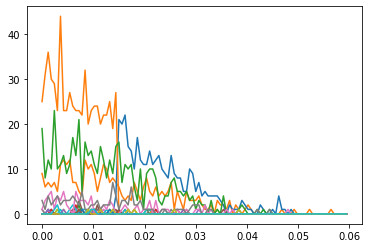

train:


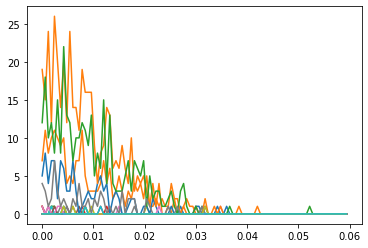

train:


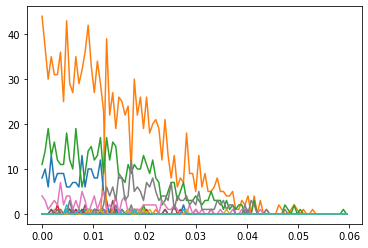

train:


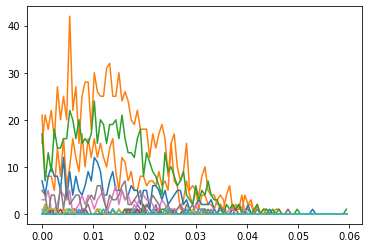

train:


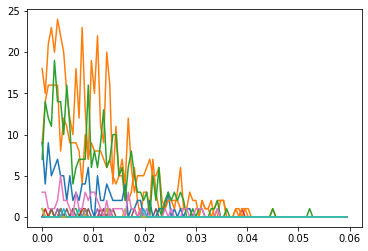

train:


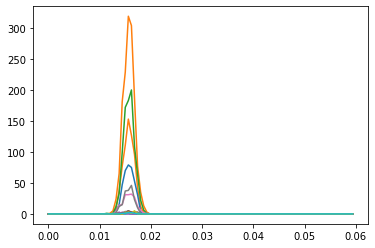

train:


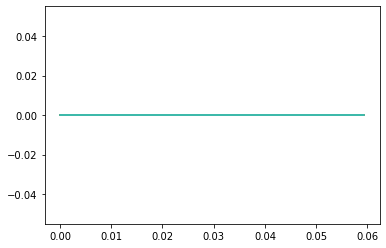

train:


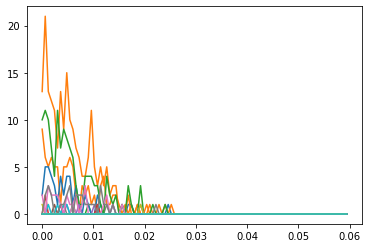

train:


KeyboardInterrupt: 

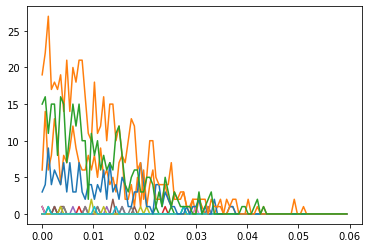

In [129]:
def toObjects(dataset):
    features, classes = dataset
    objects = []
    for i in range(len(features)):
        objects.append((features[i], classes[i]))
    return objects

train, test = trainDatasets[0], testDatasets[0]
n = len(train[0][0])
m = max(train[1])

def inside(x, l, r):
    return l <= x and x < r

for i in range(n):
    print('train:')
    objs = toObjects(train)
    objs.sort(key = lambda obj: obj[0][i])
    for j in range(m):
        xs = [0.0006 * x for x in range(100)]
        ys = [sum([obj[1] == j and inside(obj[0][i], x, x + 0.0006) for obj in objs]) for x in xs]
        plt.plot(xs, ys)
    plt.show()